In [2]:
# 데이터 분석을 위해 pandas, numpy, 시각화를 위해 matplotlib 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# 그래프 스타일 설정
plt.style.use("seaborn")
# sql 설치
! pip install PyMySQL

     |████████████████████████████████| 43 kB 1.5 MB/s 


In [3]:
import pymysql.cursors
# 데이터베이스 연결
connection = pymysql.connect(host='13.124.77.49', #EC2 아이피
                             user='USER_SQLSTK',  #데이터베이스 사용자
                             password='1qaz2wsx', #데이터베이스 암호
                             database='DB_SQLSTK', #데이터베이스 이름
                             charset='utf8',       # 언어 설정 
                             cursorclass=pymysql.cursors.DictCursor # 조회결과를 dictionary로 리턴
                             )
cursor = connection.cursor()
cursor

In [4]:
#실행할 SQL
# 2019년 1월 1일 ~ 2020년 12월 31일 삼성전자의 종가,시가,고가,저가, 거래량조회
sql = """
      SELECT T1.STK_CD,T1.DT, T1.C_PRC, T1.O_PRC, T1.H_PRC, T1.L_PRC, T1.VOL
      FROM  HISTORY_DT T1
      WHERE T1.STK_CD = '005930'
      AND T1.DT >= '2019-01-01'
      AND T1.DT <= '2019-08-01'
"""  
# SQL 쿼리를 실행할 준비를 함
cursor.execute(sql)
# SQL 쿼리를 실행하고 결과를 result에 저장
result = cursor.fetchall()
# result를 DataFrame으로 변환
df = pd.DataFrame(result)
df

,STK_CD,DT,C_PRC,O_PRC,H_PRC,L_PRC,VOL
0,005930,2019-01-02,38750.000,39400.000,39400.000,38550.000,7847664.000
1,005930,2019-01-03,37600.000,38300.000,38550.000,37450.000,12471493.000
2,005930,2019-01-04,37450.000,37450.000,37600.000,36850.000,14108958.000
3,005930,2019-01-07,38750.000,38000.000,38900.000,37800.000,12748997.000
4,005930,2019-01-08,38100.000,38000.000,39200.000,37950.000,12756554.000
...,...,...,...,...,...,...,...
140,005930,2019-07-26,47150.000,46650.000,47150.000,46550.000,7873886.000
141,005930,2019-07-29,46100.000,46800.000,47050.000,46000.000,6856846.000
142,005930,2019-07-30,46550.000,46300.000,46850.000,46300.000,5551014.000
143,005930,2019-07-31,45350.000,46200.000,46600.000,45000.000,12872916.000


In [5]:
# DT 컬럼의 타입을 날짜와 시간으로 변환
df["DT"] = pd.to_datetime (df["DT"])
# C_PRC 컬럼부터 마지막 컬럼까지의 타입을 정수로 변환
df.loc[: , "C_PRC" : ] = df.loc[: , "C_PRC" : ].astype(int)
# df의 컬럼 타입 조회
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   STK_CD  145 non-null    object        
 1   DT      145 non-null    datetime64[ns]
 2   C_PRC   145 non-null    int64         
 3   O_PRC   145 non-null    int64         
 4   H_PRC   145 non-null    int64         
 5   L_PRC   145 non-null    int64         
 6   VOL     145 non-null    int64         
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 8.1+ KB


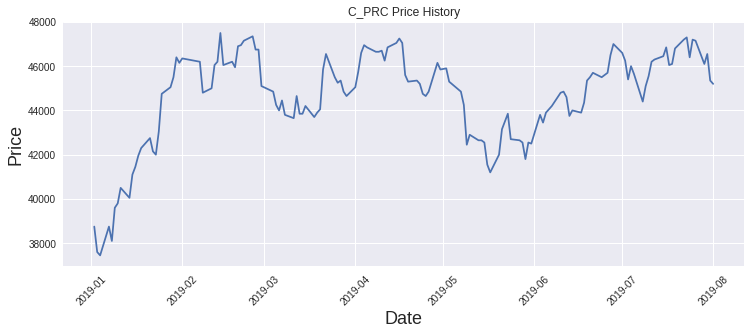

In [6]:
plt.figure(figsize=(12.2, 4.5))
plt.plot(df['DT'], df['C_PRC'], label='C_PRC')
plt.xticks(rotation=45)
plt.title('C_PRC Price History')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price', fontsize=18)
plt.show()

In [7]:
OBV = []
OBV.append(0)
for i in range(1, len(df.C_PRC)):
  if df.C_PRC[i] > df.C_PRC[i-1]:
    OBV.append(OBV[-1] + df.VOL[i])
  elif df.C_PRC[i] < df.C_PRC[i-1]:
    OBV.append(OBV[-1] - df.VOL[i])
  else:
    OBV.append(OBV[-1])

df['OBV'] = OBV
df['OBV_EMA'] = df['OBV'].ewm(com=20).mean()
df

,STK_CD,DT,C_PRC,O_PRC,H_PRC,L_PRC,VOL,OBV,OBV_EMA
0,005930,2019-01-02,38750,39400,39400,38550,7847664,0,0.000000e+00
1,005930,2019-01-03,37600,38300,38550,37450,12471493,-12471493,-6.387838e+06
2,005930,2019-01-04,37450,37450,37600,36850,14108958,-26580451,-1.344965e+07
3,005930,2019-01-07,38750,38000,38900,37800,12748997,-13831454,-1.355219e+07
4,005930,2019-01-08,38100,38000,39200,37950,12756554,-26588008,-1.641976e+07
...,...,...,...,...,...,...,...,...,...
140,005930,2019-07-26,47150,46650,47150,46550,7873886,174648404,1.353583e+08
141,005930,2019-07-29,46100,46800,47050,46000,6856846,167791558,1.369043e+08
142,005930,2019-07-30,46550,46300,46850,46300,5551014,173342572,1.386411e+08
143,005930,2019-07-31,45350,46200,46600,45000,12872916,160469656,1.396815e+08


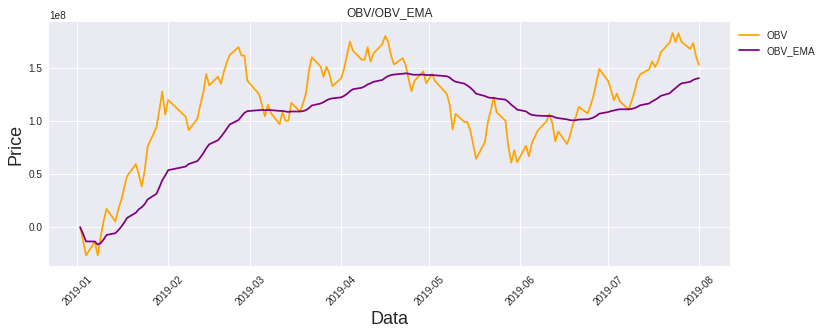

In [12]:
plt.figure(figsize=(12.2, 4.5))
plt.plot(df['DT'], df['OBV'], label='OBV', color='orange')
plt.plot(df['DT'], df['OBV_EMA'], label='OBV_EMA', color = 'purple')

plt.legend(bbox_to_anchor=(1.0, 1), fontsize = 10)

plt.xticks(rotation=45)
plt.title('OBV/OBV_EMA')
plt.xlabel('Data', fontsize=18)
plt.ylabel('Price', fontsize=18)
plt.show()

매수 / 매도 타이밍 신호 찾는 함수 생성

매수 신호: OBV > OBV_EMA
매도 신호: OBV < OBV_EMA

In [9]:
def buy_sell(signal, col1, col2):
  sigPriceBuy = []
  sigPriceSell = []
  flag = -1

  for i in range(0, len(signal)):
    if signal[col1][i] > signal[col2][i] and flag != 1:
      sigPriceBuy.append(signal['C_PRC'][i])
      sigPriceSell.append(np.nan)
      flag = 1
    
    elif signal[col1][i] < signal[col2][i] and flag != 0:
      sigPriceSell.append(signal['C_PRC'][i])
      sigPriceBuy.append(np.nan)
      flag = 0

    else:
      sigPriceBuy.append(np.nan)
      sigPriceSell.append(np.nan)
  
  return (sigPriceBuy, sigPriceSell)

In [10]:
x = buy_sell(df, 'OBV', 'OBV_EMA')
df['Buy_Signal_Price'] = x[0]
df['Sell_Signal_Price'] = x[1]
df

,STK_CD,DT,C_PRC,O_PRC,H_PRC,L_PRC,VOL,OBV,OBV_EMA,Buy_Signal_Price,Sell_Signal_Price
0,005930,2019-01-02,38750,39400,39400,38550,7847664,0,0.000000e+00,NaN,NaN
1,005930,2019-01-03,37600,38300,38550,37450,12471493,-12471493,-6.387838e+06,NaN,37600.0
2,005930,2019-01-04,37450,37450,37600,36850,14108958,-26580451,-1.344965e+07,NaN,NaN
3,005930,2019-01-07,38750,38000,38900,37800,12748997,-13831454,-1.355219e+07,NaN,NaN
4,005930,2019-01-08,38100,38000,39200,37950,12756554,-26588008,-1.641976e+07,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
140,005930,2019-07-26,47150,46650,47150,46550,7873886,174648404,1.353583e+08,NaN,NaN
141,005930,2019-07-29,46100,46800,47050,46000,6856846,167791558,1.369043e+08,NaN,NaN
142,005930,2019-07-30,46550,46300,46850,46300,5551014,173342572,1.386411e+08,NaN,NaN
143,005930,2019-07-31,45350,46200,46600,45000,12872916,160469656,1.396815e+08,NaN,NaN


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49340 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51204 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49340 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49457 missing from current font.
  font.set_te

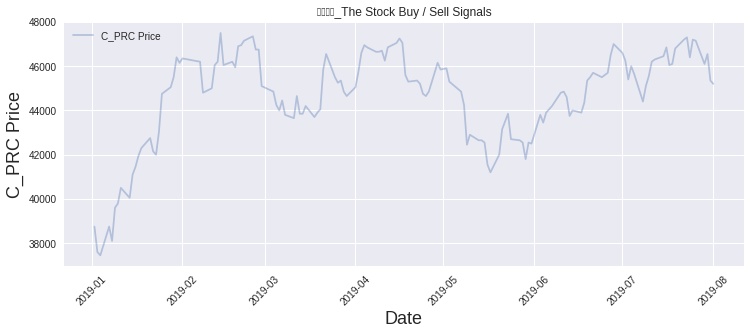

In [11]:
plt.figure(figsize=(12.2, 4.5))
# plt.scatter(df.index, df['Buy_Signal_Price'], color = 'green',
#             label = 'Buy Signal', marker = '^', alpha = 1)
# plt.scatter(df.index, df['Sell_Signal_Price'], color = 'red',
#             label = 'Sell Signal', marker = 'v', alpha = 1)
plt.plot(df['DT'], df['C_PRC'], label='C_PRC Price', alpha = 0.35)
plt.xticks(rotation = 45)
plt.title('삼성전자_The Stock Buy / Sell Signals')
plt.xlabel('Date', fontsize=18)
plt.ylabel('C_PRC Price', fontsize = 18)
plt.legend(loc = 'upper left')
plt.show()